In [149]:
import pandas as pd
import numpy as np

In [172]:
df = pd.read_parquet("C:/Users/boban/OneDrive/Desktop/S8/Classes/DLP/DL_Project/data/vivino_wines_with_weather_AOC.parquet")
df.head()

,Winery,Wine,year,vintage_rating,vintage_rating_count,wine_rating_count,wine_rating,region,price,cepages,...,GDD,TM_summer,TX_summer,temp_amp_summer,hot_days,rainy_days_summer,rain_June,rain_SepOct,frost_days_Apr,avg_TM_Apr
0,Château de Lavagnac,Bordeaux 2015,2015,3.6,76,766,3.5,bordeaux,4.10,cabernet-sauvignon,...,1860.20,22.380645,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000
1,Château de Brandey,Bordeaux Rouge 2015,2015,3.6,333,1705,3.4,bordeaux,4.90,cabernet-sauvignon,...,1860.20,22.380645,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000
2,Château Mayne-Vallet,Blaye - Côtes de Bordeaux 2015,2015,3.7,225,1497,3.5,blaye-cotes-de-bordeaux,6.00,cabernet-sauvignon,...,1651.75,21.053226,26.908065,10.653226,1.0,4.0,35.5,163.2,0.0,13.836667
3,Yvon Mau,Best Bordeaux Quality 2015,2015,3.1,136,162,3.1,bordeaux,7.50,cabernet-sauvignon,...,1860.20,22.380645,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000
4,Château Cap l'Ousteau,Haut-Médoc 2015,2015,3.7,412,3566,3.6,haut-medoc,8.98,cabernet-sauvignon,...,1651.75,21.053226,26.908065,10.653226,1.0,4.0,35.5,163.2,0.0,13.836667


In [ ]:
def add_year_norm_price(data, price_col="price", year_col="year"):
    """Add column 'year_median' + affordability weight W_price_year."""
    year_median = data.groupby(year_col)[price_col].transform("median")
    data["year_median"] = year_median
    data["W_price_year"] = year_median / (year_median + data[price_col])
    return data

In [175]:
def compute_wqi(data, prior_m=None, global_mean=None):
    """Return DataFrame with WR, WR01, W_price_year already present → adds WQI."""
    if global_mean is None:
        global_mean = data["vintage_rating"].mean()
    if prior_m is None:
        prior_m = data["vintage_rating_count"].median()

    v = data["vintage_rating_count"]
    R = data["vintage_rating"]

    data["WR"]    = (v / (v + prior_m)) * R + (prior_m / (v + prior_m)) * global_mean
    data["WR01"]  = data["WR"] / 5.0
    data["WQI"]   = data["WR01"] * data["W_price_year"]
    return data, dict(C=global_mean, m=prior_m)

In [176]:
df = add_year_norm_price(df)

In [177]:
df.head()

,Winery,Wine,year,vintage_rating,vintage_rating_count,wine_rating_count,wine_rating,region,price,cepages,...,TX_summer,temp_amp_summer,hot_days,rainy_days_summer,rain_June,rain_SepOct,frost_days_Apr,avg_TM_Apr,year_median,W_price_year
0,Château de Lavagnac,Bordeaux 2015,2015,3.6,76,766,3.5,bordeaux,4.10,cabernet-sauvignon,...,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000,55.3,0.930976
1,Château de Brandey,Bordeaux Rouge 2015,2015,3.6,333,1705,3.4,bordeaux,4.90,cabernet-sauvignon,...,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000,55.3,0.918605
2,Château Mayne-Vallet,Blaye - Côtes de Bordeaux 2015,2015,3.7,225,1497,3.5,blaye-cotes-de-bordeaux,6.00,cabernet-sauvignon,...,26.908065,10.653226,1.0,4.0,35.5,163.2,0.0,13.836667,55.3,0.902121
3,Yvon Mau,Best Bordeaux Quality 2015,2015,3.1,136,162,3.1,bordeaux,7.50,cabernet-sauvignon,...,28.890323,11.954839,4.0,6.0,34.0,71.5,0.0,14.290000,55.3,0.880573
4,Château Cap l'Ousteau,Haut-Médoc 2015,2015,3.7,412,3566,3.6,haut-medoc,8.98,cabernet-sauvignon,...,26.908065,10.653226,1.0,4.0,35.5,163.2,0.0,13.836667,55.3,0.860299


In [ ]:
GOOD_YEAR = 2018    
BAD_YEAR  = 2021    
mask_test = df["year"].isin([GOOD_YEAR, BAD_YEAR])

df_test  = df[mask_test].copy()      # 2018, 2021
df_train = df[~mask_test].copy()     # all other vintages


In [ ]:

df_full, full_params = compute_wqi(df.copy())

df_train, train_params = compute_wqi(df_train)

df_test,  test_params  = compute_wqi(df_test)

In [182]:
def quick_stats(label, data):
    print(f"\n{label}")
    print(f"  Wines:            {len(data):>6}")
    print(f"  Mean  WQI:        {data['WQI'].mean():.3f}")
    print(f"  Median WQI:       {data['WQI'].median():.3f}")
    print(f"  65th-percentile:  {data['WQI'].quantile(0.65):.3f}")

quick_stats("FULL  (includes 2018 & 2021)", df_full)
quick_stats("TRAIN (excludes 2018 & 2021)", df_train)
quick_stats("TEST  (2018 & 2021 only)  ", df_test)



FULL  (includes 2018 & 2021)
  Wines:             10055
  Mean  WQI:        0.378
  Median WQI:       0.400
  65th-percentile:  0.468

TRAIN (excludes 2018 & 2021)
  Wines:              7686
  Mean  WQI:        0.377
  Median WQI:       0.400
  65th-percentile:  0.467

TEST  (2018 & 2021 only)  
  Wines:              2369
  Mean  WQI:        0.379
  Median WQI:       0.402
  65th-percentile:  0.469


In [ ]:

combo_counts = (
    df.groupby(['cepages', 'station'])
      .size()
      .reset_index(name='count')
      .sort_values('count', ascending=False)
)
print(combo_counts)



                cepages   station  count
78           pinot-noir  21590001    999
25   cabernet-sauvignon  33394002    856
24   cabernet-sauvignon  33314005    707
73           pinot-noir  21473001    593
75           pinot-noir  21527001    478
..                  ...       ...    ...
144        shiraz-syrah  34277001      1
159        shiraz-syrah  66230001      1
156        shiraz-syrah  66137003      1
170        shiraz-syrah  84017006      1
172        shiraz-syrah  84031001      1

[179 rows x 3 columns]


Number of wines for pinot-noir at Station 21590001: 999


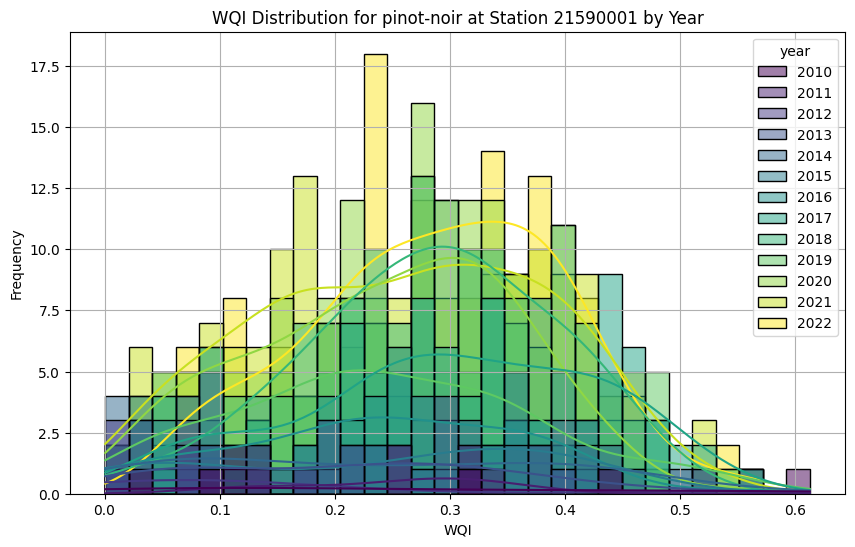

In [ ]:

cepages = "pinot-noir"
station =  "21590001"
import matplotlib.pyplot as plt
import seaborn as sns


def plot_wqi_distribution_with_years(data, cepages, station):
    subset = data[(data["cepages"] == cepages) & (data["station"] == station)]
    print(f"Number of wines for {cepages} at Station {station}: {len(subset)}")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=subset, x="WQI", hue="year", bins=30, kde=True, palette="viridis")
    plt.title(f"WQI Distribution for {cepages} at Station {station} by Year")
    plt.xlabel("WQI")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()
plot_wqi_distribution_with_years(df_full, cepages, station)


Number of wines for pinot-noir at Station 21590001: 678


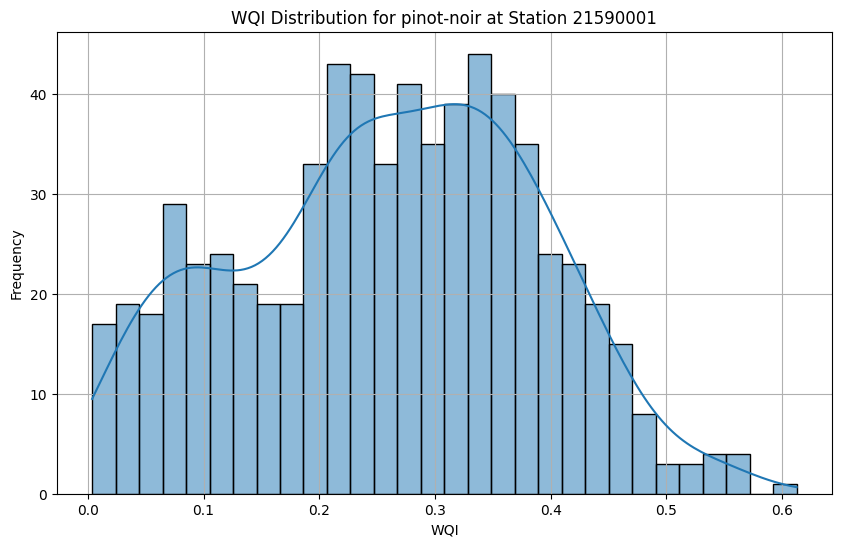

In [163]:
def plot_wqi_distribution(data, cepages, station):
    subset = data[(data["cepages"] == cepages) & (data["station"] == station)]
    print(f"Number of wines for {cepages} at Station {station}: {len(subset)}")
    plt.figure(figsize=(10, 6))
    sns.histplot(subset["WQI"], bins=30, kde=True)
    plt.title(f"WQI Distribution for {cepages} at Station {station}")
    plt.xlabel("WQI")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()
plot_wqi_distribution(df_train, cepages, station)

Number of wines for pinot-noir at Station 21590001: 678


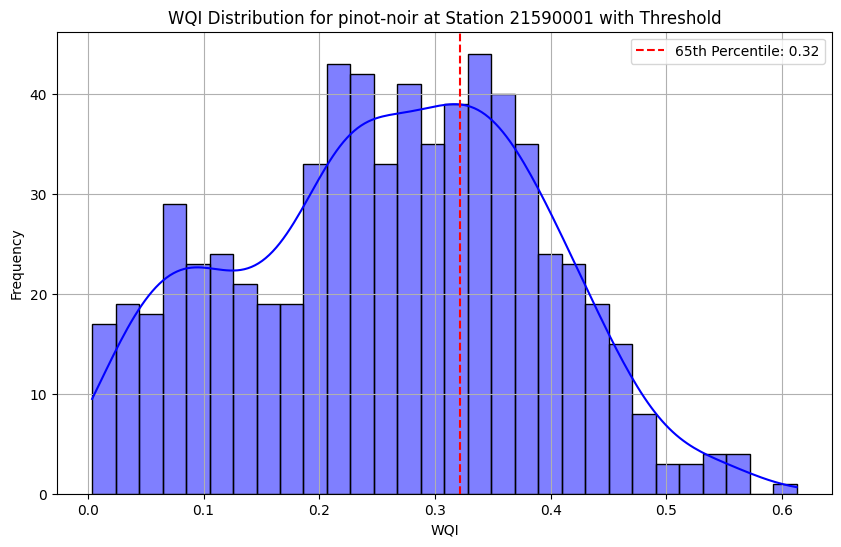

In [ ]:

def plot_wqi_distribution_with_threshold(data, cepages, station):
    subset = data[(data["cepages"] == cepages) & (data["station"] == station)]
    print(f"Number of wines for {cepages} at Station {station}: {len(subset)}")
    
    plt.figure(figsize=(10, 6))
    sns.histplot(data=subset, x="WQI", bins=30, kde=True, color='blue')
    
    # Add the threshold line
    threshold = subset["WQI"].quantile(0.65)
    plt.axvline(threshold, color='red', linestyle='--', label=f'65th Percentile: {threshold:.2f}')
    
    plt.title(f"WQI Distribution for {cepages} at Station {station} with Threshold")
    plt.xlabel("WQI")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()
plot_wqi_distribution_with_threshold(df_train, cepages, station)


In [ ]:
def label_top_65pct(df):
    df = df.copy()
    df['label'] = 0
    grouped = df.groupby(['cepages', 'station'])
    for (cepage, station), group in grouped:
        threshold = group['WQI'].quantile(0.65)
        idx = group.index[group['WQI'] > threshold]
        df.loc[idx, 'label'] = 1
    return df

df_train_label = label_top_65pct(df_train)
df_test_label = label_top_65pct(df_test)



,cepages,station,WQI,label
5798,cabernet-sauvignon,33314005,0.680511,1
5799,cabernet-sauvignon,33550001,0.664573,1
5800,cabernet-sauvignon,33550001,0.691593,1
5801,cabernet-sauvignon,33550001,0.664294,1
5802,cabernet-sauvignon,33415001,0.685586,1


In [ ]:

df_train_label.to_parquet("data/vivino_wine_train_label.parquet", index=False)
df_test_label.to_parquet("data/vivino_wine_test_label.parquet", index=False)

df_train_label.to_csv("data/vivino_wine_train_label.csv", index=False)
df_test_label.to_csv("data/vivino_wine_test_label.csv", index=False)
